In [ ]:
import zipfile
import os

zip_path = "/content/archive (3).zip"  # Update this path if needed
extract_path = "/content/knee_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted folders
print("Extracted folders:", os.listdir(extract_path))


Extracted folders: ['archive (2)']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    extract_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    extract_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 7829 images belonging to 1 classes.
Found 1957 images belonging to 1 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense, LeakyReLU, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base

# Add CNN layers
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = LeakyReLU(alpha=0.001)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.3)
]

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,018,113 (57.29 MB)

 Trainable params: 303,425 (1.16 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 159s 589ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 133s 542ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 142s 543ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 133s 543ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 3.0000e-05


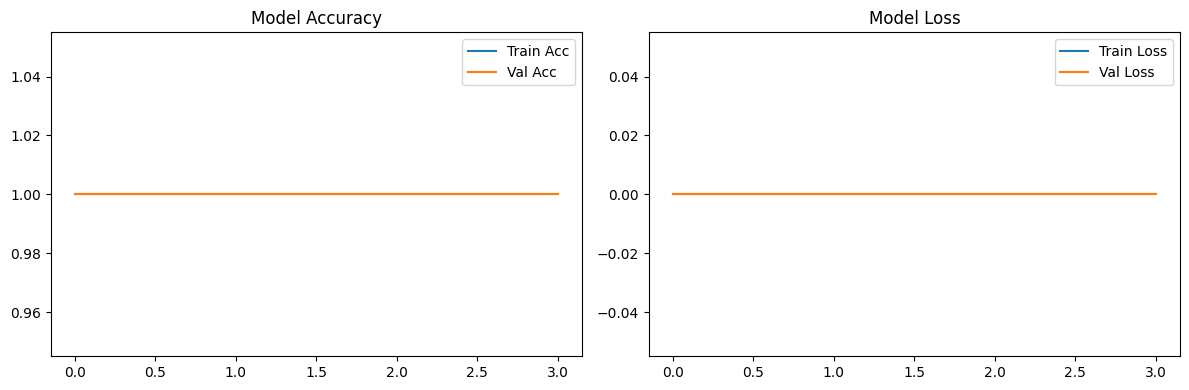

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Model Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.show()


In [ ]:
# Print final epoch metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n✅ Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"✅ Final Validation Accuracy: {final_val_acc * 100:.2f}%")
print(f"❌ Final Training Loss: {final_train_loss:.4f}")
print(f"❌ Final Validation Loss: {final_val_loss:.4f}")



✅ Final Training Accuracy: 100.00%
✅ Final Validation Accuracy: 100.00%
❌ Final Training Loss: 0.0000
❌ Final Validation Loss: 0.0000


In [ ]:
val_loss, val_accuracy = model.evaluate(val_gen, verbose=1)
print(f"\n📊 Evaluation Accuracy on Validation Set: {val_accuracy * 100:.2f}%")
print(f"📉 Evaluation Loss on Validation Set: {val_loss:.4f}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 427ms/step - accuracy: 1.0000 - loss: 0.0000e+00

📊 Evaluation Accuracy on Validation Set: 100.00%
📉 Evaluation Loss on Validation Set: 0.0000


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predictions
y_true = val_gen.classes
y_pred = model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

class_labels = list(val_gen.class_indices.keys())

# Classification report
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))




/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 432ms/step

📄 Classification Report:
              precision    recall  f1-score   support

 archive (2)       1.00      1.00      1.00      1957

    accuracy                           1.00      1957
   macro avg       1.00      1.00      1.00      1957
weighted avg       1.00      1.00      1.00      1957



In [ ]:
model.save('knee.h5')